In [1]:
from neuralprophet import NeuralProphet
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from prophet import Prophet

In [2]:
df = pd.read_csv('data/data_final.csv', 
                    parse_dates=['DateTime'])
df['DateTime'] = df['DateTime'].astype('datetime64[s]')
# df.drop('pod2', inplace=True, axis=1)
display(df.head())

print(f"Number of entries: {len(df)}")

,DateTime,pod1,pod2
0,2021-07-12 08:09:40,471740416,456708096.0
1,2021-07-12 08:09:50,471740416,456708096.0
2,2021-07-12 08:10:00,471740416,456708096.0
3,2021-07-12 08:10:10,321187840,408166400.0
4,2021-07-12 08:10:21,321187840,408166400.0


Number of entries: 17058


In [3]:
df_pod1 = df.copy()
df_pod1.drop('pod2', inplace=True, axis=1)
df_pod1 = df_pod1.rename(columns={'DateTime': 'ds', 'pod1': 'y'})
df_pod1['ds'] = df_pod1['ds'].astype('datetime64[s]')
display(df_pod1.head())

df_pod2 = df.copy()
df_pod2.drop('pod1', inplace=True, axis=1)
df_pod2 = df_pod2.rename(columns={'DateTime': 'ds', 'pod2': 'y'})
df_pod2['ds'] = df_pod2['ds'].astype('datetime64[s]')
display(df_pod2.head())

,ds,y
0,2021-07-12 08:09:40,471740416
1,2021-07-12 08:09:50,471740416
2,2021-07-12 08:10:00,471740416
3,2021-07-12 08:10:10,321187840
4,2021-07-12 08:10:21,321187840


,ds,y
0,2021-07-12 08:09:40,456708096.0
1,2021-07-12 08:09:50,456708096.0
2,2021-07-12 08:10:00,456708096.0
3,2021-07-12 08:10:10,408166400.0
4,2021-07-12 08:10:21,408166400.0


,ds,y
1,2021-07-12 08:30:00,686755840.0
2,2021-07-12 09:00:00,673185792.0
3,2021-07-12 09:30:00,690401280.0
4,2021-07-12 10:00:00,709476352.0
5,2021-07-12 10:30:00,739880960.0


,y
count,9.600000e+01
mean,7.674861e+08
std,5.825950e+07
min,6.378168e+08
25%,7.326679e+08
50%,7.704474e+08
75%,7.921838e+08
max,9.332367e+08


Length of downscaled data: 97


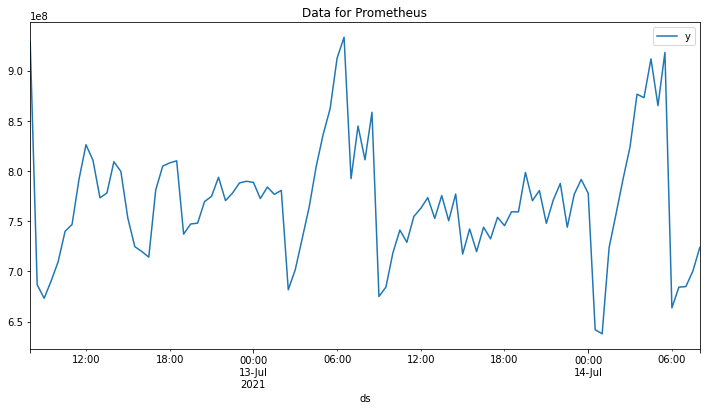

In [4]:
df_pod1 = df_pod1.set_index('ds')
df_pod1 = df_pod1.resample('30T').first()
# df_pod1.plot(figsize=(12,6), title='Data for POD1')

df_pod2 = df_pod2.set_index('ds')
df_pod2 = df_pod2.resample('30T').first()
# df_pod2.plot(figsize=(12,6), title='Data for POD2')

dff = df_pod1 + df_pod2
dff.plot(figsize=(12,6), title='Data for Prometheus')

df_pod2 = df_pod2.reset_index()
df_pod1 = df_pod1.reset_index()
dff = dff.reset_index()

dff = dff.drop([0])
display(dff.head())
display(dff.describe())
print(f"Length of downscaled data: {len(df_pod1)}")

In [5]:
date_rng = pd.date_range(start='2021-07-14 08:00:00', end='2021-08-03 07:30:00', freq='30T')
df_final = pd.DataFrame(date_rng, columns=['ds'])

dff_copy = dff.copy()
dff_copy = dff_copy.drop('ds', axis=1)

dff_copy_final = pd.DataFrame()
for i in range(10):
    dff_copy_final = dff_copy_final.append(dff_copy, ignore_index=True)
    
df_final['y'] = dff_copy_final['y']

df_final['datetime'] = pd.to_datetime(df_final['ds'])
df_final = df_final.drop('ds', axis=1)
df_final = df_final.set_index('datetime')
df_final.head()

,y
datetime,
2021-07-14 08:00:00,686755840.0
2021-07-14 08:30:00,673185792.0
2021-07-14 09:00:00,690401280.0
2021-07-14 09:30:00,709476352.0
2021-07-14 10:00:00,739880960.0


<AxesSubplot:xlabel='datetime'>

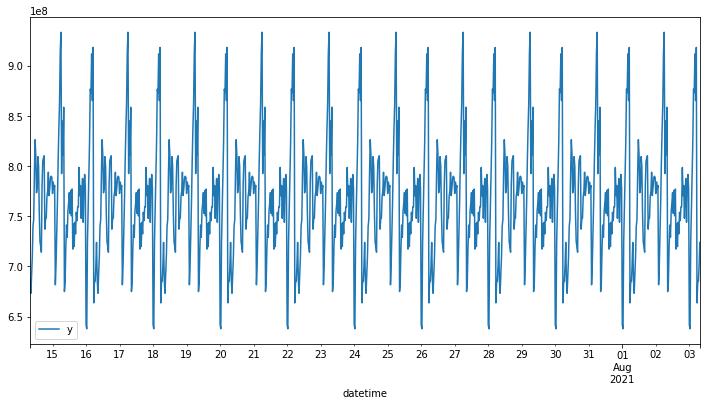

In [6]:
df_final.plot(figsize=(12,6))

In [7]:
df_final = df_final.resample('4H').first()
df_final = df_final.reset_index()
df_final = df_final.rename(columns={'datetime': 'ds'})

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train = df_final.iloc[:112]
test = df_final.iloc[112:]

train[['y']] = scaler.fit_transform(train[['y']])

len_data = len(df_final)
len_train = len(train)
len_test = len(test)

print(f"Length of training data: {len_train}")
print(f"Length of test data: {len_test}")

Length of training data: 112
Length of test data: 8


<ipython-input-8-584cab683430>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['y']] = scaler.fit_transform(train[['y']])
/home/harith/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [9]:
m = Prophet(changepoint_prior_scale=5).fit(df=train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


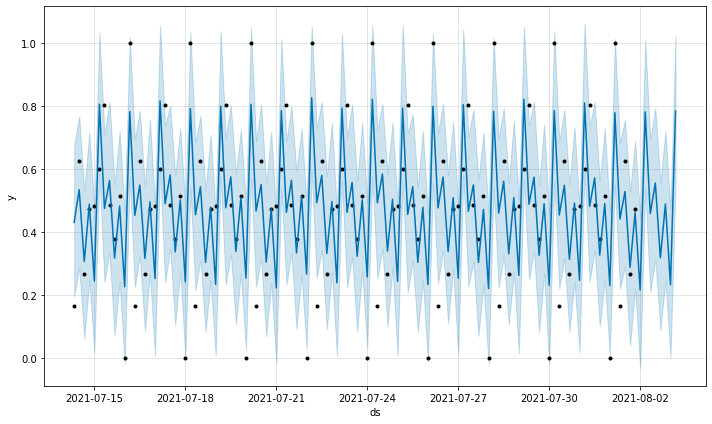

In [10]:
future = m.make_future_dataframe(periods=8, freq='4H')
fcst = m.predict(future)
fig = m.plot(fcst)

In [11]:
display(fcst.head())
len(fcst)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-07-14 08:00:00,0.452939,0.194088,0.677324,0.452939,0.452939,-0.022126,-0.022126,-0.022126,-0.011707,-0.011707,-0.011707,-0.010419,-0.010419,-0.010419,0.0,0.0,0.0,0.430813
1,2021-07-14 12:00:00,0.455395,0.287800,0.769075,0.455395,0.455395,0.079490,0.079490,0.079490,0.080464,0.080464,0.080464,-0.000974,-0.000974,-0.000974,0.0,0.0,0.0,0.534885
2,2021-07-14 16:00:00,0.457850,0.061241,0.531892,0.457850,0.457850,-0.151347,-0.151347,-0.151347,-0.159891,-0.159891,-0.159891,0.008545,0.008545,0.008545,0.0,0.0,0.0,0.306504
3,2021-07-14 20:00:00,0.460306,0.248416,0.717204,0.460306,0.460306,0.028490,0.028490,0.028490,0.012013,0.012013,0.012013,0.016477,0.016477,0.016477,0.0,0.0,0.0,0.488796
4,2021-07-15 00:00:00,0.462762,0.017230,0.476949,0.462762,0.462762,-0.218530,-0.218530,-0.218530,-0.240008,-0.240008,-0.240008,0.021478,0.021478,0.021478,0.0,0.0,0.0,0.244232


120

In [12]:
predictions = []
for i in range(len(fcst)):
    predictions.append(fcst['yhat'][i])
predictions = np.array(predictions)
predictions = predictions.reshape(len(predictions),1)

In [13]:
true_pred, train['y'] = scaler.inverse_transform(predictions), scaler.inverse_transform(np.array(train['y']).reshape(len_train, 1))
train_pred = np.array(true_pred[:len_train])
test_pred = np.array(true_pred[-len_test:])

<ipython-input-13-80bca58cd8e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_pred, train['y'] = scaler.inverse_transform(predictions), scaler.inverse_transform(np.array(train['y']).reshape(len_train, 1))


In [14]:
test['Predictions'] = test_pred
train['Predictions'] = train_pred

train = train.set_index('ds')
test = test.set_index('ds')

<ipython-input-14-5e52be1fc9a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = test_pred
<ipython-input-14-5e52be1fc9a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Predictions'] = train_pred


<AxesSubplot:xlabel='ds'>

<AxesSubplot:xlabel='ds'>

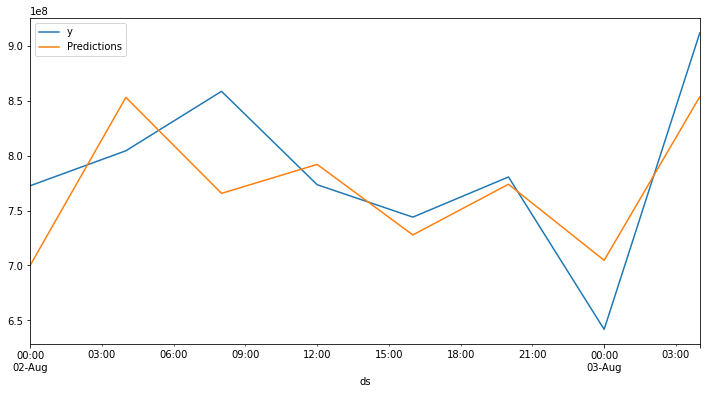

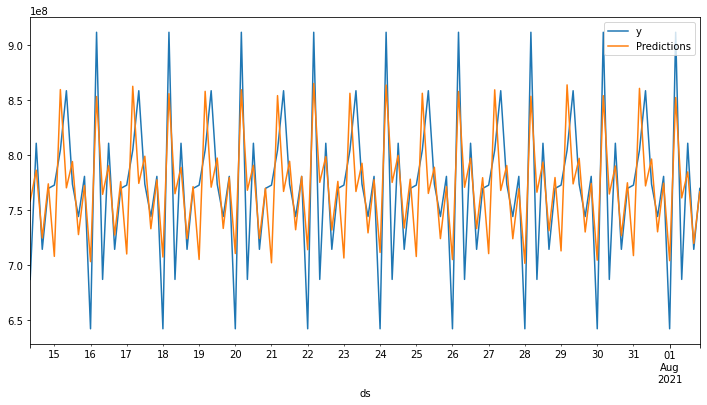

In [15]:
display(test.plot(figsize=(12,6)))
display(train.plot(figsize=(12,6)))

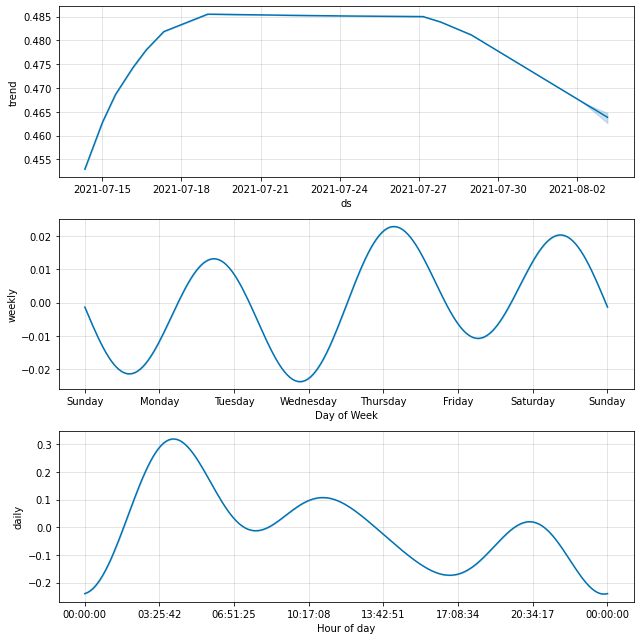

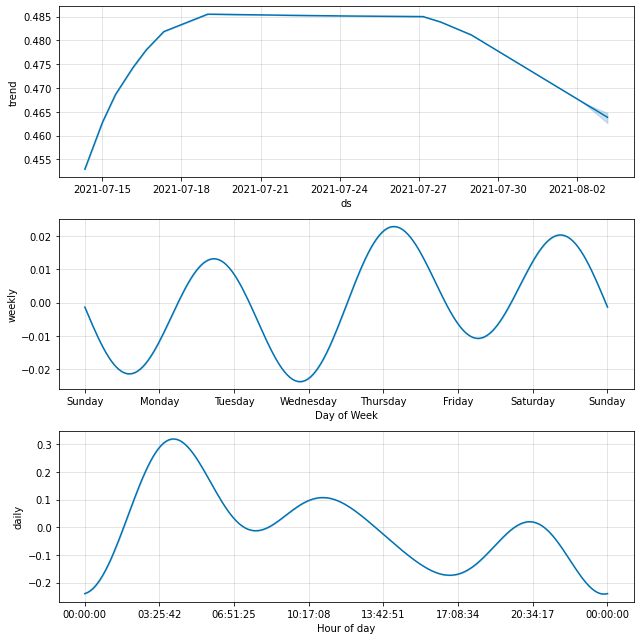

In [16]:
m.plot_components(fcst)

In [17]:
metrics = fcst.set_index('ds')[['yhat']].join(df_final.set_index('ds').y).reset_index()
metrics = metrics.iloc[:112]

In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

r2Score = r2_score(metrics.y, metrics.yhat)
mse = mean_squared_error(metrics.y, metrics.yhat)
mabse = mean_absolute_error(metrics.y, metrics.yhat)
rmse = np.sqrt(mse)

print(f"R2 Score: {r2Score}")
print(f"RMSE: {rmse}")

R2 Score: -124.83273573352852
RMSE: 774455894.931658


In [19]:
r2Score = r2_score(test.y, test.Predictions)
mse = mean_squared_error(test.y, test.Predictions)
mabse = mean_absolute_error(test.y, test.Predictions)
rmse = np.sqrt(mse)

print(f"R2 Score: {r2Score}")
print(f"RMSE: {rmse}")

R2 Score: 0.45375290460920703
RMSE: 55010842.00580152


In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(train.y, train.Predictions))

5.2528645875206825
